In [1]:
# pip install imbalanced-learn

In [2]:
from tqdm.notebook import tqdm
import matplotlib
import pandas as pd
import numpy as np
import os

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, Normalizer

%matplotlib inline
np.random.seed(42)

In [3]:
PATH = 'santander-customer-satisfaction'
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'
label_column = 'TARGET'

In [4]:
df_train_completo = pd.read_csv('/'.join([PATH, TRAIN_FILE]))
df_train = df_train_completo.copy()

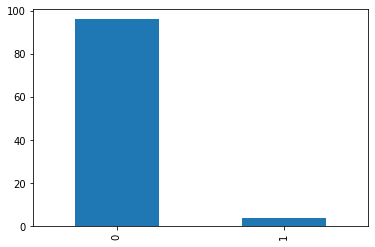

In [5]:
(df_train.TARGET.value_counts()/len(df_train)*100).plot.bar();

# Pré-processamento
## Tranformacoes de Variaveis

In [6]:
# Elimina features com apenas um valor
print(len(df_train.columns))
for coluna in tqdm(df_train.columns) :
    if len(df_train[coluna].unique()) == 1:
        del(df_train[coluna])
print(len(df_train.columns))

# Elimina coluna ID
del(df_train['ID'])

371



337


## Normalizacao de dados

In [7]:
# Normalizamos features binarias para 0 ou 1
def transforma_colunas_binarias(df):
    for (coluna,um_dos_valores) in tqdm(LISTA_TRANSFORMACAO_EM_BINARIO):
        df.loc[:,coluna] = df[coluna].apply(lambda x: 1 if x==um_dos_valores else 0)
    return df

LISTA_TRANSFORMACAO_EM_BINARIO = []
for coluna in tqdm(df_train.columns) :
    valores_possiveis = df_train[coluna].unique()
    if (len(valores_possiveis) ==2) and coluna != 'TARGET':
        LISTA_TRANSFORMACAO_EM_BINARIO.append((coluna, valores_possiveis[0])) 
        
df_train = transforma_colunas_binarias(df_train)

In [8]:
# Normalizacao dos features quantitativas
COLUNAS_UTILIZADAS = list(df_train.columns)
colunas_features = [i for i in COLUNAS_UTILIZADAS if i!= label_column]
COLUNAS_QUANTITATIVAS = list(set(colunas_features) - set([i[0] for i in LISTA_TRANSFORMACAO_EM_BINARIO]))

print('Normalizando os dados')
scaler = Normalizer()
df_train.loc[:,COLUNAS_QUANTITATIVAS] = scaler.fit_transform(df_train.loc[:,COLUNAS_QUANTITATIVAS])

Normalizando os dados


## Selecao de features mais relevantes 

In [9]:
print('Calculando correlação')
df_correlacao = df_train.corr()

Calculando correlação


In [10]:
# print('Calculando correlação')
# df_correlacao = df_train.corr()

# Eliminamos variaveis que possuem muita correlacao entre si
lista_colunas = df_correlacao.columns # mesma ordem para colunas e indices

correlacao_alta = 0.99
set_colunas_a_eliminar = set()

print(len(df_train.columns))
for index_linha,lista_valores in enumerate(df_correlacao.values):
    for index_coluna,valor in enumerate(lista_valores):
        if valor != 1 and abs(valor)>correlacao_alta:
            coluna1 = lista_colunas[index_linha]
            coluna2 = lista_colunas[index_coluna]
            # se nenhuma das duas ja vai ser eliminadas eliminamos a primeira
            if (coluna1 not in set_colunas_a_eliminar) and (coluna2 not in set_colunas_a_eliminar):
                set_colunas_a_eliminar.add(coluna1)
            
df_train = df_train.drop(columns=set_colunas_a_eliminar)
print(len(df_train.columns))
colunas_features = list(set(colunas_features) - set_colunas_a_eliminar)

336
290


In [11]:
# Selecinamos as features mais relevantes utilizando um modelo ensemble
X = df_train[colunas_features].values
y = df_train[label_column].values

# Criamos dados sinteticos da classe minoritaria devido problema de desbalenciamento de classes
print('Criando dados sinteticos')
oversample = SMOTE(sampling_strategy=0.65)
X, y = oversample.fit_resample(X, y)
display(pd.Series(y).value_counts())

print('Treinando modelo para selecao de features')
modelo = RandomForestClassifier(n_jobs=-1,)
modelo.fit(X, y)
IMPORTANCIA_MINIMA_ACEITAVEL = 0.012

print('Selecionando as features')
colunas_relevantes = []
for variavel, importancia in zip(colunas_features,modelo.feature_importances_):
    if importancia>IMPORTANCIA_MINIMA_ACEITAVEL:
        colunas_relevantes.append(variavel)
        print(variavel, importancia)

Criando dados sinteticos


0    73012
1    47457
dtype: int64

Treinando modelo para selecao de features
Selecionando as features
ind_var30 0.018481821722189158
num_var45_ult1 0.012712656168596338
saldo_var5 0.022041604449816544
num_var5 0.0251242352636294
num_var30_0 0.020719999538680048
num_meses_var5_ult3 0.01472292020451865
var3 0.016850072934972423
num_var30 0.022694341610988048
num_var45_hace3 0.030058099318454757
num_var35 0.01793551184338426
num_var22_ult1 0.015971695125536516
num_var22_hace3 0.0212401671934154
num_var45_ult3 0.027763278756605003
saldo_var30 0.028583004481480368
num_var39_0 0.015630770047550292
var15 0.12148375504770792
var38 0.01774308786188026
saldo_medio_var5_hace3 0.020090806873025568
num_var45_hace2 0.01767061648074133
saldo_medio_var5_ult3 0.02323119269582511
num_var22_hace2 0.024257107785418442
num_var41_0 0.0155425167712026
num_meses_var39_vig_ult3 0.017557795840135348
num_var22_ult3 0.03014664678927664
saldo_medio_var5_hace2 0.01869520929223353
saldo_medio_var5_ult1 0.018526159150043853
num_var42 0.023765929563833

## PCA

In [12]:
print(f'features relevantes: {len(colunas_relevantes)}')
# Treinamos PCA para poder aplicar outra transformacao nos dados
X = df_train[colunas_relevantes].values
y = df_train[label_column].values
display(pd.Series(y).value_counts())

# oversample = SMOTE(sampling_strategy=0.80)
X, y = oversample.fit_resample(X, y)
display(pd.Series(y).value_counts())

NUMERO_COMPONENTES = 15
pca = PCA(n_components=NUMERO_COMPONENTES)
pca = pca.fit(X)
X = pca.transform(X)

features relevantes: 33


0    73012
1     3008
dtype: int64

0    73012
1    47457
dtype: int64

# Treinamento

In [13]:
# Split dos dados
print('Realizando split dos dados')
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

# estimate scale_pos_weight value
scale_pos_weight = len(y[y==0]) / len(y[y==1])
print('Estimate: %.3f' % scale_pos_weight)

# Modelo
print('Criando o modelo')
clf = XGBClassifier(
    n_jobs=-1,
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    objective= 'binary:logitraw',
    max_depth=6,
    gamma=0.1
)

# Treinamento
print('Treinando o modelo')
clf = clf.fit(X_train, y_train)

print('\n\nSCORE:')
score_treinamento = roc_auc_score(y_train, clf.predict(X_train))
score_teste = roc_auc_score(y_test, clf.predict(X_test))

print(f'ROC AUC train: {score_treinamento}')
print(f'ROC AUC test: {score_teste}')

# Confusion matriz
print('Confusion matriz train:')
display(pd.crosstab(y_train,clf.predict(X_train), rownames=['True'], colnames=['Pred']))
print('Confusion matriz test:')
display(pd.crosstab(y_test,clf.predict(X_test), rownames=['True'], colnames=['Pred']))

Realizando split dos dados
Estimate: 1.538
Criando o modelo
Treinando o modelo


SCORE:
ROC AUC train: 0.8541258692213242
ROC AUC test: 0.8267354489222734
Confusion matriz train:


Pred,0,1
True,,
0,48842,5917
1,6538,29054


Confusion matriz test:


Pred,0,1
True,,
0,16003,2250
1,2649,9216


# Validação
Utilizando dados com target desconhecidos

In [14]:
df_test_original = pd.read_csv('/'.join([PATH, TEST_FILE]))
df_test = df_test_original.copy()

In [15]:
# Binarizacao
print('Transforma colunas binarias')
df_test = transforma_colunas_binarias(df_test)

# Normalizacao
print('Normaliza features quantitativas')
df_test.loc[:,COLUNAS_QUANTITATIVAS] = scaler.fit_transform(df_test.loc[:,COLUNAS_QUANTITATIVAS])

# Eliminacao de features irrelevantes
print('Elimina Features irrelevantes')
df_test = df_test[colunas_features]

# Eliminacao de features com baixo score no rf
print('Elimina Features com baixo score no modelo ensemble')
df_test = df_test[colunas_relevantes]
print('FIM')

Transforma colunas binarias



Normaliza features quantitativas
Elimina Features irrelevantes
Elimina Features com baixo score no modelo ensemble
FIM


In [16]:
y_pred_test = clf.predict(pca.transform(df_test.values))
df_test_original['TARGET'] = y_pred_test

In [17]:
df_test_original[['ID', 'TARGET']].set_index('ID', drop=True).to_csv('resposta__.csv')

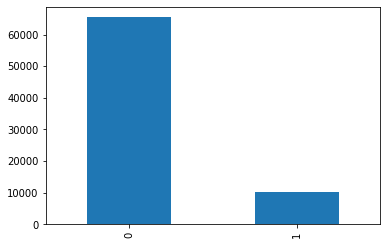

In [18]:
df_test_original.TARGET.value_counts().plot(kind='bar');